# Caches and Data Locality

In [1]:
import timeit
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
%%bash
make clean

rm -f -rf *~ *.o *.mod *.MOD *.i core.* *.out *.lst *.x *.x+orig *.x+[0-9]* *.dat *.report result_*.py report*.txt


Modern CPUs have a hierarchy of cache memories which try to hide latencies of reading/writing from/to main memory.

![cache hierarchy](img/cache_hierarchy.png)

 Go over to a `File &rarr; New &rarr; Terminal` and type `lscpu` to learn more about the caches that the CPUs we are currently working on.

| Link            | Size |
|-----------------|-----------|
| **L1 cache** | 32 KB per core |
| **L2 cache** | 256 KB per core |
| **L3 cache** | 30 MB |
| **RAM**| 64 GB |

It is important to note that if all cores are busy, we only have approximately 2.5 MB per core of L3 cache. The main reason to have caches is to be able to hide the low latencies and low bandwidth of system memory (RAM) accesses. The bandwiths on our Intel E5-2690 v3 Processor between the different elements of the memory hierarchy are the following:

| Link            | Bandwidth | Latency |
|-----------------|-----------|---------|
| **L1 &harr; core** | read 155 GB/s + rrite 77.5 GB/s per core | >= 4 cycles |
| **L1 &harr; L2**   | 155 GB/s per core | >= 11 cycles |
| **L2 &harr; L3**   | 77.5 GB/s | >= 36 cycles |
| **L3 &harr; RAM**  | 68.3 GB/s | >= 100 cycles |

The latencies corresponds to the time it takes to load a random element from a specific element of the memory hierarchy. It is important to note that the connections L2 &harr; L3 and L3 &harr; RAM have to feed all 12 cores, and so are comparably slow as compared to the bandwidths L2 &harr; L1 and L1 &harr; core. For example, if all cores are keeping the L2 &harr; L3 link busy, the 77.5 GB/s have to be shared and each core only has 6.5 GB/s available.

## Data arrays in memory

To understand how a computer program utilizes caches, it is important to know how data arrays are stored in the memory of a computer. Let's first look at how a one-dimensional data array `field(i)` is stored in memory. In the illustration below, `field` is of type `real (kind=4)` which is equal to `float32` or a floating-point value that occupies 4 bytes in memory. The elements of the array are stored consecutively in memory starting with the first element `field(1)`.

![1d array](img/1d_array.png)

For a two-dimensional array `field(i,j)` on has to choose in which order to store the elements. There are two choices. Either `field(2,1)` is the second element after `field(1,1)` (column major layout) or `field(1,2)` (row major layout), and so on. The illustration below shows column major layout, which is used in Fortran. Other languages (C or Python) use row major layout.

![2d array](img/2d_array.png)

The important things to realize is that while the elements `field(1,1)` and `field(2,1)` are right next to each other in memory, the elements `field(1,1)` and `field(1,2)` can potentially be very far from each other in memory, depending on the size $nx$ of the first dimension (see [this page](https://agilescientific.com/blog/2018/12/28/what-is-the-fastest-axis-of-an-array) for more details). The jump in memory when moving from `f(i,j)` to `f(i+1,j)` is called *i-stride*. Similarly, the jump in memory when moving from `f(i,j)` to `f(i,j+1)` is called *j-stride*.

In weather and climate models, the most important data arrays are three-dimensional `field(i,j,k)` where `i,j,k` correspond to the two horizontal and the vertical dimension. In our stencil program, we often chose `nx = 128`, `ny = 128`, `nz = 64`. It is a reasonable assumption that a weather and climate model has 64 vertical levels.

So how much memory does such a field use in memory? If every value is stored as `float32` we use 4 bytes per value and have a total of `nx` x `ny` x `nz` values. That is a total of 4'194'304 bytes or 4.0 MBs.

| Dimension       | Value (for 128 x 128 x 64) |
|-----------------|-----------|
| i-stride        | 4 Bytes   |
| j-stride        | 512 Bytes (4 x nx) |
| k-stride        | 64 KBytes (4 x nx x ny) |
| full field      | 4 MBytes (4 x nx x ny x nz) |

## Cache optimization

Optimizations often focus on optimizing cache usage. What does this actually mean? Consider the following computer program written in Fortran.

<code>
real (kind=4) :: a(128), b(127)

do i = 1, 127
  b(i) = 0.5 * ( a(i) + a(i+1) )
end do
</code>

In the first iteration `i=1` we load `a(1)` and `a(2)` from system memory into L3, L2 and then L1. Oncde we have computed `b(1)` we move to the next `i=2` and here we need to load `a(2)` and `a(3)`. While `a(3)` has to come from system memory (RAM), `a(2)` is already in L1 cache. Simiarly, for `i=3` we have `a(3)` already in cache. Basically, for executing this loop, we only have to do 128 loads from system memory even though our programs issues 254 loads. We have a 50% L1 hit rate, since 50% of our loads can be satisfied out of L1.

Imagine we have a Frotran program with two triply nested loops as shown below and our field sizes are `nx=128`, `ny=128` and `nz=64`. The first iteration of the first triply nested loop will read `a(1,1,1)` from system memory (RAM) into L3, L2, and L1 cache. This is a costly operation (>= 100 cycles, see above). Once we have the value `a(1,1,1)` we store it in `b(1,1,1)`. As we continue iterating through the first triply nested loop, more values of `a`, namely `a(2,1,1)`, `a(3,1,1)`, `a(4,1,1)`, ... come streaming into the caches. But at some point L1 is no longer able to keep a copy of `a(1,1,1)` and has to make room in favor of new data coming in (cache eviction). At a later point, also L2 is full and has to evict `a(1,1,1)` in favor of new data coming in. Since our full field `a` is 4 MB in total size, even L3 cannot retain `a(1,1,1)` as we are iterating through the first triply nested loop (in case all 12 cores are also all streaming in new data). By the time we reach the last element `a(nx,ny,nz)` of the first triply nested loop, `a(1,1,1)` is no longer present in any of the caches. So when we start the next triply nested loop, `a(1,1,1)` has to be loaded once more from RAM and we pay the high cost of having to load it twice.

<code>
do k = 1, nz
  do j = 1, ny
    do i = 1, nx
      b(i,j,k) = a(i,j,k)
    end do
  end do
end do

do k = 1, nz
  do j = 1, ny
    do i = 1, nx
      c(i,j,k) = a(i,j,k)
    end do
  end do
end do
</code>

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> There is no need to write two separate <tt>k</tt>-loops in the code example above. We can write the code above with a single <tt>k</tt>-loop. Now we have one <tt>k</tt>-loop and inside the <tt>k</tt>-loop we have to blocks which each consist of a doubly-nested <tt>i,j</tt>-loop. Compute the size of a <tt>i,j</tt>-plane in memory. Now redo the argument above again, step-by-step. Is the second access to <code>a(1,1,1)</code> still from main memory? If not, which level of cache can the value be retrieved from?<br>
<b>2.</b> If you assume that the runtime is solely determined by the number of system memory (RAM) accesses, what would be the expected speedup of the new version with a single <tt>k</tt>-loop as compared to the original one?<br>
</div>

*Solution:*
1. If we fuse the two k-loops, we write read one full i,j-plane of a(:,:,k) into memory. This corresponds to nx x ny x 4 Bytes = 128 x 128 x 4 Bytes = 64 KB of contiguous memory and fits into L2 cache (but is too large for L1 cache), even if b and c are also in cache. So when we read the same i,j-plane of a again it is still in cache.
2. In the original version (one k-loop), we would read (R) a and write (W) b in the first loop next. Then in the second loop nest we would read (R) a again and write (W) c. All R and W operations are from/to system memory. In the case where we fuse the k-loop, the second read (R) of a is for free, since it can be served from cache. So we reduce the number of system memory accesses from 4 to 3 and would expect a speedup of 4/3 = 1.3x

## Loop fusion

We first define the method we will be using to validate the output of the stencil2d program below.

In [3]:
def read_field_from_file(filename, num_halo=None):
    (rank, nbits, num_halo, nx, ny, nz) = np.fromfile(filename, dtype=np.int32, count=6)
    offset=(3 + rank) * 32 // nbits
    data = np.fromfile(filename, dtype=np.float32 if nbits == 32 else np.float64, \
                       count=nz * ny * nx + offset)
    if rank == 3:
        return np.reshape(data[offset:], (nz, ny, nx))
    else:
        return np.reshape(data[offset:], (ny, nx))

def validate_results():
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    in_field = read_field_from_file('in_field.dat')
    k_lev = in_field.shape[0] // 2
    im1 = axs[0].imshow(in_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im1, ax=axs[0]);
    axs[0].set_title('Initial condition (k = {})'.format(k_lev));

    out_field = read_field_from_file('out_field.dat')
    k_lev = out_field.shape[0] // 2
    im2 = axs[1].imshow(out_field[k_lev, :, :], origin='lower', vmin=-0.1, vmax=1.1);
    fig.colorbar(im2, ax=axs[1]);
    axs[1].set_title('Final result (k = {})'.format(k_lev));
    
    plt.show()

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> Make a copy of <tt>stencil2d-orig.F90</tt> and name it <tt>stencil2d-kblocking.F90</tt>. Make a new version of the <tt>subroutine laplace</tt> called <tt>subroutine laplace_2d</tt> which only works on an <tt>i,j</tt>-plane. Try to fuse everything in the iteration loop except the halo update. There should only be a single <tt>k</tt>-loop left. You should be able to make <tt>tmp1_field</tt> and <tt>tmp2_field</tt> two-dimensional arrays. Compile, run and validate the your results are still the same. Compare the runtimes of the version you have just made against the orig version. How much speedup did you achieve? Try to understand in the code where the system memory accesses are happening and where loads can be satisfied out of cache.<br>
</div>

In [4]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make VERSION=orig
make VERSION=kblocking

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c m_utils.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-orig.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-orig.o -o stencil2d-orig.x
cp stencil2d-orig.x stencil2d.x
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-kblocking.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-kblocking.o -o stencil2d-kblocking.x
cp stencil2d-kblocking.x stencil2d.x


In [5]:
%%bash
srun -n 12 ./stencil2d-orig.x --nx 128 --ny 128 --nz 64 --num_iter 128

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,     128,  0.1459328E+01], \
] )


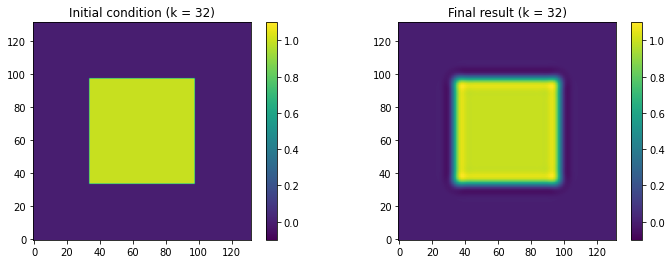

In [6]:
validate_results()

In [7]:
%%bash
srun -n 12 ./stencil2d-kblocking.x --nx 128 --ny 128 --nz 64 --num_iter 128

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,     128,  0.5654534E+00], \
] )


srun: Job 23140745 step creation temporarily disabled, retrying (Requested nodes are busy)
srun: Step created for job 23140745


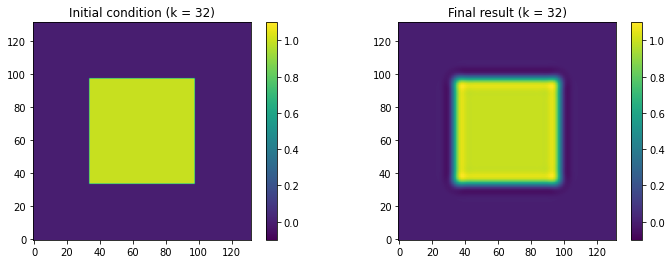

In [8]:
validate_results()

## Inlining

Another common optimization is to replace subroutine or function calls with the actual code that is being executed. This optimization technique is called inlining and often offers up new avenues to optimize the code either manually or automatically by the compiler. In our case this means replacing the <code>call laplace_2d()</code> with the actual implementation.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>4.</b> Make a copy of <tt>stencil2d_kblocking.F90</tt> and name it <tt>stencil2d_inlining.F90</tt>. Inline the two calles to <code>laplace_2d()</code> with the actual content of the subroutine. Recompile, run, and validate that the results are still the same. Is there more potential for fusing loops which are exactly the same? Can you demote additional arrays?<br>
<b>5.</b> Make a copy of <tt>stencil2d-orig.F90</tt> and name it <tt>stencil2d-kblocking.F90</tt>. Make a new version of the <tt>subroutine laplace</tt> called <tt>subroutine laplace_2d</tt> which only works on an <tt>i,j</tt>-plane. Try to fuse everything in the iteration loop except the halo update. There should only be a single <tt>k</tt>-loop left. You should be able to make <tt>tmp1_field</tt> and <tt>tmp2_field</tt> two-dimensional arrays. Compile and run both versions and compare the runtimes. How much speedup did you achieve? Try to understand in the code where the system memory accesses are happening and where loads can be satisfied out of cache.<br>
<b>6.</b> Would it be possible to fuse the remainig <tt>i,j</tt>-loops? If no, why not?<br>
<b>7. (Bonus)</b> Add the results from the optimized versions of the code to the roofline model chart in the previous notebook.<br>
<b>8. (Bonus)</b> Run the perftools-lite for the different versions of the code (see previous notebook) and read the reports. Do the performance numbers corroborate our hypothesis of what the fusion of the k-loop and the inlining did in terms of system memory (RAM) transfer?<br>
</div>

In [9]:
%%bash
module load daint-gpu
module switch PrgEnv-gnu PrgEnv-cray

make VERSION=inlining

ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm -c stencil2d-inlining.F90
ftn -O3 -hfp3 -eZ -ffree -N255 -ec -eC -eI -eF -rm m_utils.o stencil2d-inlining.o -o stencil2d-inlining.x
cp stencil2d-inlining.x stencil2d.x


In [10]:
%%bash
srun -n 12 ./stencil2d-inlining.x --nx 128 --ny 128 --nz 64 --num_iter 128

# ranks nx ny ny nz num_iter time
data = np.array( [ \
[   12,  128,  128,   64,     128,  0.2810705E+00], \
] )


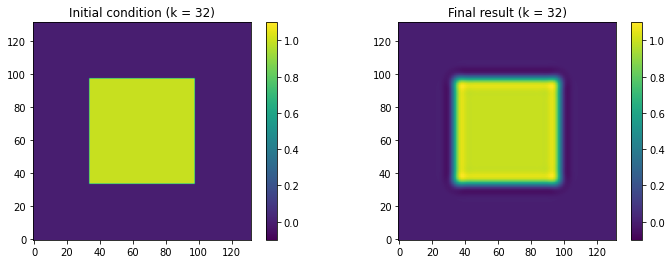

In [11]:
validate_results()

## Runtime vs. Array size

Our analyses above were dependent on the specific assumptions we made regarding the size of the data arrays. We were always assuming that `nx=128`, `ny=128`, and `nz=64`. The code below will run all versions we have generate so far (orig, kblocking, inlining) and scan different settings of `nx` and `ny`

Be patient, executing all versions for all configurations will take some time. If you want more accurate numbers and have a lot of patience, running with `num_iter=1024` will give you clearer results.

In [12]:
%%bash
for tag in orig kblocking inlining ; do
    echo "=> running stencil2d-${tag}.x in scan mode (output in result_stencil2d-${tag}.py)"
    srun -n 12 ./stencil2d-${tag}.x --scan --nz 64 --num_iter 128 1> result_stencil2d-${tag}.py
done

=> running stencil2d-orig.x in scan mode (output in result_stencil2d-orig.py)
=> running stencil2d-kblocking.x in scan mode (output in result_stencil2d-kblocking.py)
=> running stencil2d-inlining.x in scan mode (output in result_stencil2d-inlining.py)


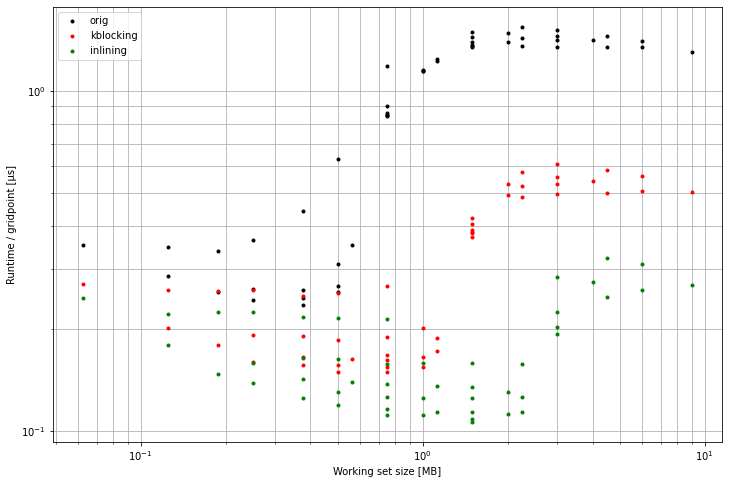

In [13]:
tags = [ "orig", "kblocking", "inlining" ]
colors = [ "black", "red", "green", "blue" ]
for tag, color in zip(tags, colors):
    exec(open("result_stencil2d-" + tag + ".py").read())
    vars()["data_" + tag] = data
    nxnynz = data[:, 1] * data[:, 2] * data[:, 3]
    runtime = data[:, 5]
    plt.loglog( nxnynz * 4 / 1024. / 1024., runtime / nxnynz * 1.0e6 , '.', color=color);
plt.xlabel( 'Working set size [MB]' );
plt.ylabel( 'Runtime / gridpoint [µs]' );
plt.grid(b=True, which='both')
plt.legend(tags)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>9.</b> The plot above shows runtime per gridpoint vs. the size of a full three-dimensional <code>nx x ny x nz</code> field with <code>float32</code>. Do you understand why the curves move to the right and bottom when moving from orig to kblocking to inlining?<br>
</div>

*Solution:*
- The performance of our stencil2d program is determined by waiting for memory access since it has a low arithmetic intensity (memory bound). The curves move down since our optimized versions are doing less transfers to system memory. As a consequence, the amount of time it takes to update a single gridpoint in a single iteration goes down.
- The curves move to the right, because the number of full 3d fields that are being read on every iteration decreases. The domains can be slightly larger before we fall out of a the L3 cache (which has 2.5 MB per core).